# Chatbot With MCP Server

In [1]:
%pip install langchain langgraph langchain-openai langchain-community langchain-tavily langchain-mcp-adapters mcp pywin32 -Uq

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['TAVILY_API_KEY'] = os.getenv("tavily_key")

## 도구 정의

In [3]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)  # 검색결과 3개
tavily_tool.invoke('랭그래프에서 노드란 무엇인가요?')

{'query': '랭그래프에서 노드란 무엇인가요?',
 'response_time': 0.82,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://normalstory.tistory.com/entry/LangGraph-01',
   'title': 'LangGraph - 1. 개요 - 청춘만화 - 티스토리',
   'content': "***\\*지극히 주관적 개요:*** *Devika, Crew AI, phidata를 사용하면서 또는 사용할수록 강하게 느껴지는 점이 하나 있다면 지금 중요한 것은 ’ 프롬프트나 RAG가 아니라 얼마나 Agentic 한 LLM 애플리케이션을 얼마나 Locally 하게 구성할 수 있는가 ‘라고 생각한다.* *물론 이때 구성의 주체는 operater가 아니라 End-User이다. LangGraph는 Agent 런타임에 자주 필요한 '**주기적 그래프***workflows containing**cycles*'를 더 잘 생성할 수 있도록 LangChain 위에 구축된 모듈이다. 그리고 프로세스의 '방향'은 프로세스 내 워크의 상태(실행 여부나 그 상태) 정보를 기반으로 이뤄지는데 이러한 일련의 내용은 기본적으로 scratch 코딩과 같이\xa0그래프( workflows,\xa0diagram)형태로 표현될 수 있다. 2. 속성의 값을 추가하는 말 그대로 '업데이트'하는 방식이 있는데 이 경우 속성이 수행된 작업의 목록(또는 이와 유사한 것)인 경우 노드가 수행한 새로운 작업을 반환하고 해당 작업이 속성에 자동으로 추가되도록 하려는 경우 사용될 수 있다. 이때 노드는 다양한 형태(역할)로 정의될 수 있는데 하나의 체인처럼 생각할 수 있고, 실제로도 실행 가능하기 때문에 하나의 도구가 되거나 체인의 역할을 할 수도 있다. 그래프를 컴파일을 하기 전에 'entry point'역할을 하는 노드를 지정하고 'end point'를 세

### MCP Server 연동
- `http` 원격지의 MCP Server를 web 방식 호출
- `stdio` MCP Client system에서 MCP Server구동하는 경우

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient  # MCP 멀티 서버 클라이언트

CONTEXT7_API_KEY = os.getenv('CONTEXT7_API_KEY')

# MCP 서버 설정으로 클라인트 객체 생성
mcp_client = MultiServerMCPClient({
    # LangChain Docs MCP 서버
    "docs-langchain": {
        "url": "https://docs.langchain.com/mcp",  # 엔드포인트
        "transport": 'http'  # 전송방식
    },
    # Context7 MCP 서버
    "context7": {
        "url": "https://mcp.context7.com/mcp",    # 엔드포인트
        "headers": {  # 인증 헤더
            "CONTEXT7_API_KEY": CONTEXT7_API_KEY
        },
        "transport": 'http'
    }
})

# get_tools는 비동기메서드이므로 이를 await를 붙여 처리한다.
mcp_tools = await mcp_client.get_tools()  # 연결된 MCP 서버들의 Tool 목록 조회
mcp_tools

[StructuredTool(name='SearchDocsByLangChain', description='Search across the Docs by LangChain knowledge base to find relevant information, code examples, API references, and guides. Use this tool when you need to answer questions about Docs by LangChain, find specific documentation, understand how features work, or locate implementation details. The search returns contextual content with titles and direct links to the documentation pages.', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': 'Search query'}, 'apiReferenceOnly': {'type': 'boolean', 'description': 'Only return API reference docs'}, 'codeOnly': {'type': 'boolean', 'description': 'Only return code snippets'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000001FBE293E480>),
 StructuredTool(name='resolve-li

In [6]:
# Tavily + MCP Tools를 바인딩한 LLM 노드(chatbot) 구성
from langchain.chat_models import init_chat_model

llm = init_chat_model('gpt-4.1-mini')
tools = [tavily_tool] + mcp_tools
llm_with_tools = llm.bind_tools(tools)  # LLM에 도구 스펙 바인딩 (필요시 tool call 생성)

# 상태를 입력받아 응답을 messages에 추가해주는 노드 함수
def chatbot(state):
    response = llm_with_tools.invoke(state['messages'])  # 누적된 메시지로 LLM 호출 (도구 필요시 ToolCall 포함)
    return {'messages': [response]}  # add_messages 규칙에 의해 기존 messages에 응답이 누적

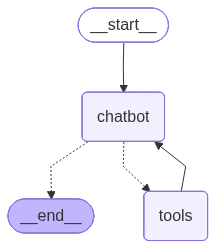

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition  # 사전 구현된 ToolNode / 분기 조건 함수
from typing import TypedDict, Annotated, List             # 상태 타입 정의용
from langgraph.graph import add_messages, StateGraph, START, END  # 메시지 누적 / 그래프 구성 요소

# 그래프에서 사용할 상태 스키마
class State(TypedDict):
    messages: Annotated[List, add_messages]  # messages는 add_messages 규칙으로 리스트 누적 저장

builder = StateGraph(State)  # State 기반 그래프 설계 객체 생성
tool_node = ToolNode(tools)  # 바인딩한 tools로 ToolNode 객체 생성

builder.add_node('chatbot', chatbot)  # LLM 호출 노드
builder.add_node('tools', tool_node)  # 도구 실행 노드

builder.add_edge(START, 'chatbot')
builder.add_conditional_edges('chatbot', tools_condition)  # tool call 필요시 tool로, 아니면 END로 분기
builder.add_edge('tools', 'chatbot')  # tools 실행 후 chatbot에서 최종 응답 생성

graph = builder.compile()  # 그래프로 컴파일
graph

In [11]:
user_query = '최근 원화-달러 환율은 어떻게 돼?'
state = {'messages': [('human', user_query)]}
response = graph.invoke(state)
print(response['messages'][-1].content)

최근 원화-달러 환율은 약 1,458원 부근입니다. 구체적으로는 1달러에 1,458.35원 정도이며, 환율이 약간 하락하는 중입니다. 더 자세한 사항이나 실시간 변동은 환전 전문 사이트나 금융 정보를 확인하시면 좋겠습니다.


In [ ]:
user_query = 'langchain v1.2에서 달라진 점은 뭐야?'
state = {'messages': [('human', user_query)]}
response = await graph.ainvoke(state)  # 그래프 비동기 실행 (필요시 MCP/웹 도구 호출)
print(response['messages'][-1].content)

LangChain v1.2에서 달라진 주요 사항은 다음과 같습니다:

1. create_agent 함수 도입:
   - new standard로서 에이전트를 생성하는 간단한 인터페이스를 제공합니다.
   - 이전의 langgraph.prebuilt.create_react_agent를 대체합니다.
   - 미들웨어를 통한 확장과 맞춤설정이 가능하며, 모델, 도구, 시스템 프롬프트 지정이 필요합니다.

예시 코드:
```python
from langchain.agents import create_agent

agent = create_agent(
    model="claude-sonnet-4-5-20250929",
    tools=[search_web, analyze_data, send_email],
    system_prompt="You are a helpful research assistant."
)

result = agent.invoke({
    "messages": [
        {"role": "user", "content": "Research AI safety trends"}
    ]
})
```

2. 네임스페이스 단순화:
   - langchain 네임스페이스를 에이전트 핵심 빌딩 블록에 집중하도록 단순화했습니다.
   - 기존의 레거시 기능들은 langchain-classic 패키지로 이동됐습니다.
   - import 경로가 변경되어 기존 코드에서 langchain 대신 langchain-classic을 사용하도록 업데이트가 필요합니다.

즉, v1.2는 에이전트 생성을 더욱 간소화하고 코드 구조를 정리하여 개발자 경험을 개선한 버전입니다.


C:\Users\Playdata\AppData\Local\Temp\ipykernel_22992\3362626543.py:3: RuntimeWarning: coroutine 'Pregel.ainvoke' was never awaited
  response = await graph.ainvoke(state)


In [16]:
user_query = '파이썬 3.13에서 새롭게 바뀐 내용이 뭐야? context7 tool을 사용해 줘.'
state = {'messages': [('human', user_query)]}
response = await graph.ainvoke(state)  # 그래프 비동기 실행 (필요시 MCP/웹 도구 호출)
print(response['messages'][-1].content)

Python 3.13에서 새롭게 바뀐 주요 내용은 다음과 같습니다:

1. 새로운 인터랙티브 인터프리터 개선이 포함되었습니다.
2. 실험적으로 Free-threaded 모드에서 실행하는 기능이 추가되었습니다 (PEP 703).
3. Just-In-Time (JIT) 컴파일러가 도입되었습니다 (PEP 744).
4. 에러 메시지가 기본적으로 색상으로 하이라이트되어 더 읽기 쉬워졌습니다.
5. 내장 함수 locals()가 반환하는 매핑 변경에 대해 정의된 의미를 갖게 되었습니다.
6. 타입 파라미터가 기본값을 지원합니다.
7. 오랜 기간 사용 중단(deprecated)되어 온 표준 라이브러리 모듈들이 삭제되었습니다 (PEP 594).

이 외에도 표준 라이브러리의 사용자 친화성과 정확성이 향상되었고, 여러 deprecated API와 모듈이 제거되었습니다. 

필요하면 특정 기능에 대해 더 자세히 설명해 드릴 수 있습니다.


In [17]:
user_query = '봄이 시작하는 걸 알려주는 절기가 뭐야?'
state = {'messages': [('human', user_query)]}
response = graph.invoke(state)  # 그래프 실행 (도구 호출 없이 사용)
print(response['messages'][-1].content)

봄이 시작하는 것을 알려주는 절기는 "입춘"입니다. 입춘은 24절기 중 첫 번째 절기로 대개 2월 4일경에 해당하며, 입춘이 지나면 본격적인 봄이 시작된다고 여겨집니다. 입춘은 봄이 시작되는 시기의 기준이 되는 절기로 봄의 시작을 알리는 중요한 절기입니다.
